In [94]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from catboost import CatBoostRegressor
from tqdm import tqdm

warnings.filterwarnings('ignore')

train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
sample_submission = pd.read_csv("./data/sample_submission.csv")
age_gender_info = pd.read_csv("./data/age_gender_info.csv")
age_gender_spec = pd.DataFrame(age_gender_info['지역'])
population = pd.read_csv('./data/population.csv')
population.columns = ['지역','인구수']
age_gender_spec['2060'] = age_gender_info[['20대(남자)','20대(여자)','30대(남자)','30대(여자)',
                                          '40대(남자)','40대(여자)','50대(남자)','50대(여자)',
                                          '60대(남자)','60대(여자)','70대(남자)','70대(여자)']].sum(axis=1)
age_gender_spec = age_gender_spec.merge(population, on='지역')
age_gender_spec['생산가능인구'] = np.round(age_gender_spec['인구수'] * age_gender_spec['2060'])
# age_gender_spec['4050'] = age_gender_info[['40대(남자)','40대(여자)','50대(남자)','50대(여자)']].sum(axis=1)
# age_gender_spec['6070'] = age_gender_info[['60대(남자)','60대(여자)','70대(남자)','70대(여자)']].sum(axis=1)
plt.rc('font', family='NanumGothic')
plt.rc('axes', unicode_minus=False)

train.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수', '등록차량수'
]

test.columns = [
    '단지코드', '총세대수', '임대건물구분', '지역', '공급유형', '전용면적', '전용면적별세대수', '공가수', '자격유형',
    '임대보증금', '임대료', '지하철', '버스',
    '단지내주차면수'
]

categorial_variable = ["임대건물구분", "지역", "공급유형", "자격유형"]
continious_variable = ["총세대수", "전용면적", "전용면적별세대수", "공가수", "임대보증금", "임대료",
                       "단지내주차면수"]



# test_x_unique
# gbr: 72.57647194273466
# rfr: 19.73668358714044
# {'max_depth': 12, 'min_samples_leaf': 8, 'min_samples_split': 16, 'n_estimators': 100} -62.07652539964124
# 144.17 143.65

TypeError: __init__() missing 1 required positional argument: 'values'

In [98]:
def sorter(column):
    test_index = pd.Categorical(column, categories=pd.unique(test['단지코드']),ordered=True)
    return pd.Series(test_index)


def pre_processing(x, flag):
    x = x.fillna(0)
    x.loc[x['임대료'] == '-', ['임대료']] = 0
    x.loc[x['임대보증금'] == '-', ['임대보증금']] = 0
    x[['임대료', '임대보증금']] = x[['임대료', '임대보증금']].astype('int64')

    x['전용면적'] = x['전용면적'] // 5 * 5
    idx = x[x['전용면적'] > 100].index
    x.loc[idx, '전용면적'] = 100
    idx = x[x['전용면적'] < 15].index
    x.loc[idx, '전용면적'] = 15
    columns = ['단지코드', '총세대수', '공가수', '지역', '단지내주차면수', '지하철', '버스', '공급유형', '임대건물구분', '자격유형']
    target = "등록차량수"
    area_columns = []
    for area in x['전용면적'].unique():
        area_columns.append(f'면적_{area}')

    new_x = pd.DataFrame()
    for i, code in tqdm(enumerate(x['단지코드'].unique())):
        temp = x[x['단지코드'] == code]
        temp.index = range(temp.shape[0])
        for col in columns:
            new_x.loc[i, col] = temp.loc[0, col]

        for col in area_columns:
            area = float(col.split('_')[-1])
            new_x.loc[i, col] = temp[temp['전용면적'] == area]['전용면적별세대수'].sum()

        if flag == True:
            new_x.loc[i, '등록차량수'] = temp.loc[0, '등록차량수']
    
    new_x = new_x.merge(age_gender_spec[['지역','생산가능인구','2060']], on='지역', sort=False)
    new_x = pd.get_dummies(new_x, columns=categorial_variable)
    new_x = new_x[[c for c in new_x if c not in ['등록차량수']] + [c for c in ['등록차량수'] if c in new_x]]
    # scaler = RobustScaler()
    # x[continious_variable] = scaler.fit_transform(x[continious_variable])
    return new_x

differ_variables = ['공급유형_공공임대(5년)', '공급유형_공공임대(10년)', '자격유형_B', '자격유형_F',
                    '지역_서울특별시', '공급유형_공공분양', '공급유형_장기전세', '자격유형_D',
                    '면적_65.0']

if len(test[test['자격유형'].isnull() == True]) > 0:
    test.loc[test['자격유형'].isnull() == True, ['자격유형']] = ('A', 'C')

new_train = pre_processing(train, True)
new_test = pre_processing(test, False)


423it [00:07, 59.60it/s]
150it [00:02, 65.17it/s]


In [103]:
new_test = new_test.sort_values(by="단지코드", key=sorter).drop('index', axis=1)

for c in differ_variables:
    new_test[c] = 0

x_train = new_train.iloc[:, 1:-1]
y_train = new_train.iloc[:, -1]
x_test = new_test.iloc[:, 1:]

rfr = RandomForestRegressor(n_estimators=200, max_depth=15, min_samples_leaf=1,
                            min_samples_split=4, random_state=46)
cbr = CatBoostRegressor(loss_function='MAE', random_state=75)
model = cbr
train_X, test_X, train_y, test_y = train_test_split(x_train, y_train, test_size=0.2, random_state=93)

new_test

,단지코드,총세대수,공가수,단지내주차면수,지하철,버스,면적_35.0,면적_45.0,면적_50.0,면적_30.0,...,자격유형_M,자격유형_N,공급유형_공공임대(5년),자격유형_B,자격유형_F,지역_서울특별시,공급유형_공공분양,공급유형_장기전세,자격유형_D,면적_65.0
0,C1072,754.0,14.0,683.0,0.0,2.0,116.0,262.0,376.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,C1128,1354.0,9.0,1216.0,0.0,3.0,420.0,356.0,578.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,C1456,619.0,18.0,547.0,0.0,16.0,165.0,196.0,132.0,82.0,...,0,0,0,0,0,0,0,0,0,0
3,C1840,593.0,7.0,543.0,0.0,3.0,335.0,174.0,84.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,C1332,1297.0,11.0,1112.0,0.0,2.0,425.0,568.0,304.0,0.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,C2456,349.0,17.0,270.0,0.0,4.0,138.0,96.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
146,C1266,596.0,35.0,593.0,0.0,1.0,304.0,107.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
147,C2152,120.0,9.0,40.0,0.0,1.0,0.0,0.0,0.0,54.0,...,0,0,0,0,0,0,0,0,0,0
148,C1267,675.0,38.0,467.0,0.0,1.0,126.0,180.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
model.fit(train_X, train_y)
pred = model.predict(test_X)
print(mean_absolute_error(test_y, pred))


0:	learn: 274.6705317	total: 2.02ms	remaining: 2.02s
1:	learn: 269.0678342	total: 4.28ms	remaining: 2.13s
2:	learn: 264.3625018	total: 6.11ms	remaining: 2.03s
3:	learn: 259.7643290	total: 8.1ms	remaining: 2.02s
4:	learn: 255.3353323	total: 9.78ms	remaining: 1.95s
5:	learn: 250.6998010	total: 11.4ms	remaining: 1.9s
6:	learn: 246.5913902	total: 13.4ms	remaining: 1.9s
7:	learn: 241.6418881	total: 15.1ms	remaining: 1.88s
8:	learn: 238.1937068	total: 17ms	remaining: 1.88s
9:	learn: 234.0036383	total: 18.8ms	remaining: 1.86s
10:	learn: 230.2392904	total: 20.7ms	remaining: 1.86s
11:	learn: 227.0475743	total: 22.5ms	remaining: 1.85s
12:	learn: 223.7618869	total: 24.1ms	remaining: 1.83s
13:	learn: 220.3987278	total: 26.4ms	remaining: 1.86s
14:	learn: 217.5489811	total: 28.2ms	remaining: 1.85s
15:	learn: 214.3059783	total: 30.5ms	remaining: 1.88s
16:	learn: 211.5181943	total: 32.8ms	remaining: 1.89s
17:	learn: 208.8139331	total: 34.9ms	remaining: 1.9s
18:	learn: 205.8047050	total: 37.1ms	remaini

179:	learn: 80.3018850	total: 310ms	remaining: 1.41s
180:	learn: 80.0629738	total: 312ms	remaining: 1.41s
181:	learn: 79.7339728	total: 314ms	remaining: 1.41s
182:	learn: 79.3993972	total: 316ms	remaining: 1.41s
183:	learn: 79.2012883	total: 319ms	remaining: 1.41s
184:	learn: 78.9883911	total: 321ms	remaining: 1.41s
185:	learn: 78.8772528	total: 323ms	remaining: 1.41s
186:	learn: 78.5637101	total: 325ms	remaining: 1.41s
187:	learn: 78.4125301	total: 327ms	remaining: 1.41s
188:	learn: 78.2650932	total: 329ms	remaining: 1.41s
189:	learn: 77.8489496	total: 331ms	remaining: 1.41s
190:	learn: 77.7250076	total: 333ms	remaining: 1.41s
191:	learn: 77.4112330	total: 335ms	remaining: 1.41s
192:	learn: 77.1905898	total: 336ms	remaining: 1.41s
193:	learn: 76.8526715	total: 338ms	remaining: 1.4s
194:	learn: 76.4255471	total: 339ms	remaining: 1.4s
195:	learn: 76.2511342	total: 341ms	remaining: 1.4s
196:	learn: 76.0163204	total: 342ms	remaining: 1.4s
197:	learn: 75.8065088	total: 344ms	remaining: 1.3

352:	learn: 52.5425887	total: 618ms	remaining: 1.13s
353:	learn: 52.4023285	total: 621ms	remaining: 1.13s
354:	learn: 52.3504364	total: 623ms	remaining: 1.13s
355:	learn: 52.2936709	total: 625ms	remaining: 1.13s
356:	learn: 52.2539464	total: 627ms	remaining: 1.13s
357:	learn: 52.1009397	total: 629ms	remaining: 1.13s
358:	learn: 52.0397186	total: 630ms	remaining: 1.13s
359:	learn: 51.9602975	total: 633ms	remaining: 1.13s
360:	learn: 51.6633467	total: 635ms	remaining: 1.12s
361:	learn: 51.5821070	total: 637ms	remaining: 1.12s
362:	learn: 51.4110558	total: 638ms	remaining: 1.12s
363:	learn: 51.3942315	total: 640ms	remaining: 1.12s
364:	learn: 51.2911226	total: 642ms	remaining: 1.12s
365:	learn: 51.1508528	total: 644ms	remaining: 1.11s
366:	learn: 51.0532637	total: 646ms	remaining: 1.11s
367:	learn: 51.0045011	total: 648ms	remaining: 1.11s
368:	learn: 50.8867642	total: 650ms	remaining: 1.11s
369:	learn: 50.8301536	total: 651ms	remaining: 1.11s
370:	learn: 50.6985016	total: 653ms	remaining:

511:	learn: 40.1736824	total: 926ms	remaining: 883ms
512:	learn: 40.1189966	total: 928ms	remaining: 881ms
513:	learn: 40.0945813	total: 930ms	remaining: 880ms
514:	learn: 40.0611941	total: 933ms	remaining: 879ms
515:	learn: 40.0441243	total: 935ms	remaining: 877ms
516:	learn: 40.0345231	total: 936ms	remaining: 875ms
517:	learn: 40.0197974	total: 938ms	remaining: 873ms
518:	learn: 39.9675127	total: 940ms	remaining: 871ms
519:	learn: 39.8745849	total: 942ms	remaining: 869ms
520:	learn: 39.8611879	total: 943ms	remaining: 867ms
521:	learn: 39.8519441	total: 945ms	remaining: 865ms
522:	learn: 39.7727315	total: 946ms	remaining: 863ms
523:	learn: 39.7572422	total: 948ms	remaining: 861ms
524:	learn: 39.6910948	total: 950ms	remaining: 860ms
525:	learn: 39.6299524	total: 952ms	remaining: 858ms
526:	learn: 39.6067302	total: 953ms	remaining: 856ms
527:	learn: 39.5626128	total: 955ms	remaining: 854ms
528:	learn: 39.5501398	total: 957ms	remaining: 852ms
529:	learn: 39.5363423	total: 958ms	remaining:

679:	learn: 33.0715205	total: 1.24s	remaining: 581ms
680:	learn: 33.0174923	total: 1.24s	remaining: 580ms
681:	learn: 33.0090913	total: 1.24s	remaining: 579ms
682:	learn: 32.9962785	total: 1.24s	remaining: 577ms
683:	learn: 32.9861768	total: 1.25s	remaining: 576ms
684:	learn: 32.9724780	total: 1.25s	remaining: 574ms
685:	learn: 32.9295762	total: 1.25s	remaining: 573ms
686:	learn: 32.8183969	total: 1.25s	remaining: 571ms
687:	learn: 32.7412045	total: 1.25s	remaining: 569ms
688:	learn: 32.7256553	total: 1.26s	remaining: 568ms
689:	learn: 32.6576204	total: 1.26s	remaining: 566ms
690:	learn: 32.6516478	total: 1.26s	remaining: 564ms
691:	learn: 32.6397736	total: 1.26s	remaining: 563ms
692:	learn: 32.5607478	total: 1.27s	remaining: 561ms
693:	learn: 32.5396675	total: 1.27s	remaining: 559ms
694:	learn: 32.5204408	total: 1.27s	remaining: 557ms
695:	learn: 32.5082335	total: 1.27s	remaining: 556ms
696:	learn: 32.4532928	total: 1.27s	remaining: 554ms
697:	learn: 32.4306592	total: 1.28s	remaining:

890:	learn: 26.9427355	total: 1.71s	remaining: 209ms
891:	learn: 26.9330534	total: 1.71s	remaining: 207ms
892:	learn: 26.9279635	total: 1.71s	remaining: 205ms
893:	learn: 26.9150571	total: 1.72s	remaining: 204ms
894:	learn: 26.8872644	total: 1.72s	remaining: 202ms
895:	learn: 26.8252488	total: 1.72s	remaining: 200ms
896:	learn: 26.7620979	total: 1.72s	remaining: 198ms
897:	learn: 26.7100222	total: 1.73s	remaining: 196ms
898:	learn: 26.7027216	total: 1.73s	remaining: 194ms
899:	learn: 26.6832557	total: 1.73s	remaining: 192ms
900:	learn: 26.6434090	total: 1.73s	remaining: 190ms
901:	learn: 26.6401819	total: 1.73s	remaining: 188ms
902:	learn: 26.6013622	total: 1.74s	remaining: 187ms
903:	learn: 26.5746171	total: 1.74s	remaining: 185ms
904:	learn: 26.5685114	total: 1.74s	remaining: 183ms
905:	learn: 26.5248468	total: 1.74s	remaining: 181ms
906:	learn: 26.4937788	total: 1.74s	remaining: 179ms
907:	learn: 26.4901047	total: 1.75s	remaining: 177ms
908:	learn: 26.4787816	total: 1.75s	remaining:

In [8]:
cv_score = cross_val_score(model, x_train, y_train, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1)
print(np.mean(cv_score * -1))


133.8135978574715


In [11]:
params = {
        'n_estimators': [200],
        'max_depth': [15],
        'min_samples_leaf': [1],
        'min_samples_split': [4],
    }

cat_params = {
    'random_state':range(1,100)
}
grid = GridSearchCV(model, param_grid=cat_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid.fit(x_train, y_train)
pred = grid.predict(x_test)

print(grid.best_params_, grid.best_score_)
print(mean_absolute_error(x_test['단지내주차면수'],pred))

0:	learn: 283.4838998	total: 2.21ms	remaining: 2.2s
1:	learn: 279.1680300	total: 4.14ms	remaining: 2.06s
2:	learn: 273.9904908	total: 5.95ms	remaining: 1.98s
3:	learn: 269.5507408	total: 7.83ms	remaining: 1.95s
4:	learn: 264.7767351	total: 9.63ms	remaining: 1.92s
5:	learn: 260.3462801	total: 11.4ms	remaining: 1.89s
6:	learn: 255.8136531	total: 13.1ms	remaining: 1.86s
7:	learn: 251.3105353	total: 14.9ms	remaining: 1.85s
8:	learn: 247.3933304	total: 16.8ms	remaining: 1.84s
9:	learn: 243.1164277	total: 18.6ms	remaining: 1.84s
10:	learn: 239.1030658	total: 20.4ms	remaining: 1.83s
11:	learn: 234.5387823	total: 22ms	remaining: 1.81s
12:	learn: 231.2316044	total: 23.8ms	remaining: 1.81s
13:	learn: 227.6521476	total: 25.7ms	remaining: 1.81s
14:	learn: 223.4779998	total: 27.5ms	remaining: 1.81s
15:	learn: 220.2643857	total: 29.5ms	remaining: 1.81s
16:	learn: 217.0670794	total: 31.3ms	remaining: 1.81s
17:	learn: 213.4689956	total: 33.2ms	remaining: 1.81s
18:	learn: 210.0268616	total: 35ms	remain

156:	learn: 95.9609733	total: 310ms	remaining: 1.66s
157:	learn: 95.5386200	total: 312ms	remaining: 1.66s
158:	learn: 95.2807903	total: 314ms	remaining: 1.66s
159:	learn: 95.1279432	total: 316ms	remaining: 1.66s
160:	learn: 94.9473614	total: 318ms	remaining: 1.66s
161:	learn: 94.7440945	total: 320ms	remaining: 1.65s
162:	learn: 94.4538652	total: 322ms	remaining: 1.65s
163:	learn: 93.9349618	total: 323ms	remaining: 1.65s
164:	learn: 93.8050060	total: 324ms	remaining: 1.64s
165:	learn: 93.4246940	total: 328ms	remaining: 1.65s
166:	learn: 93.2065797	total: 331ms	remaining: 1.65s
167:	learn: 92.8510584	total: 333ms	remaining: 1.65s
168:	learn: 92.6834201	total: 336ms	remaining: 1.65s
169:	learn: 92.5123579	total: 338ms	remaining: 1.65s
170:	learn: 92.3196142	total: 341ms	remaining: 1.65s
171:	learn: 92.1663726	total: 343ms	remaining: 1.65s
172:	learn: 91.8204020	total: 345ms	remaining: 1.65s
173:	learn: 91.4019542	total: 347ms	remaining: 1.65s
174:	learn: 91.0870738	total: 349ms	remaining:

394:	learn: 57.6637772	total: 781ms	remaining: 1.2s
395:	learn: 57.6089481	total: 783ms	remaining: 1.19s
396:	learn: 57.5193539	total: 786ms	remaining: 1.19s
397:	learn: 57.4708819	total: 788ms	remaining: 1.19s
398:	learn: 57.4152810	total: 790ms	remaining: 1.19s
399:	learn: 57.3398345	total: 792ms	remaining: 1.19s
400:	learn: 57.2289347	total: 793ms	remaining: 1.19s
401:	learn: 57.0808377	total: 795ms	remaining: 1.18s
402:	learn: 57.0605463	total: 797ms	remaining: 1.18s
403:	learn: 56.9871333	total: 799ms	remaining: 1.18s
404:	learn: 56.9359185	total: 801ms	remaining: 1.18s
405:	learn: 56.8550168	total: 803ms	remaining: 1.17s
406:	learn: 56.7851776	total: 804ms	remaining: 1.17s
407:	learn: 56.7379060	total: 806ms	remaining: 1.17s
408:	learn: 56.5959525	total: 808ms	remaining: 1.17s
409:	learn: 56.5279626	total: 810ms	remaining: 1.17s
410:	learn: 56.3669374	total: 813ms	remaining: 1.16s
411:	learn: 56.3177439	total: 814ms	remaining: 1.16s
412:	learn: 56.2171584	total: 816ms	remaining: 

568:	learn: 46.0423021	total: 1.1s	remaining: 835ms
569:	learn: 45.9104905	total: 1.1s	remaining: 833ms
570:	learn: 45.8635836	total: 1.1s	remaining: 831ms
571:	learn: 45.8532019	total: 1.11s	remaining: 829ms
572:	learn: 45.7874844	total: 1.11s	remaining: 827ms
573:	learn: 45.7484185	total: 1.11s	remaining: 825ms
574:	learn: 45.7081866	total: 1.11s	remaining: 823ms
575:	learn: 45.5874047	total: 1.11s	remaining: 821ms
576:	learn: 45.5266063	total: 1.12s	remaining: 819ms
577:	learn: 45.4617421	total: 1.12s	remaining: 816ms
578:	learn: 45.3788331	total: 1.12s	remaining: 814ms
579:	learn: 45.3015668	total: 1.12s	remaining: 812ms
580:	learn: 45.2630672	total: 1.12s	remaining: 810ms
581:	learn: 45.2350242	total: 1.12s	remaining: 807ms
582:	learn: 45.2047195	total: 1.13s	remaining: 805ms
583:	learn: 45.1393663	total: 1.13s	remaining: 803ms
584:	learn: 45.0980808	total: 1.13s	remaining: 801ms
585:	learn: 45.0240417	total: 1.13s	remaining: 798ms
586:	learn: 44.9799635	total: 1.13s	remaining: 79

767:	learn: 36.6742292	total: 1.42s	remaining: 429ms
768:	learn: 36.6649445	total: 1.42s	remaining: 427ms
769:	learn: 36.6443227	total: 1.42s	remaining: 425ms
770:	learn: 36.6090597	total: 1.43s	remaining: 423ms
771:	learn: 36.5930865	total: 1.43s	remaining: 422ms
772:	learn: 36.5853200	total: 1.43s	remaining: 420ms
773:	learn: 36.5492339	total: 1.43s	remaining: 418ms
774:	learn: 36.5290835	total: 1.43s	remaining: 416ms
775:	learn: 36.4880770	total: 1.43s	remaining: 414ms
776:	learn: 36.4741018	total: 1.44s	remaining: 412ms
777:	learn: 36.4669194	total: 1.44s	remaining: 410ms
778:	learn: 36.3656004	total: 1.44s	remaining: 408ms
779:	learn: 36.3584508	total: 1.44s	remaining: 406ms
780:	learn: 36.3485313	total: 1.44s	remaining: 404ms
781:	learn: 36.3231516	total: 1.44s	remaining: 402ms
782:	learn: 36.2252385	total: 1.45s	remaining: 400ms
783:	learn: 36.1988274	total: 1.45s	remaining: 399ms
784:	learn: 36.1517298	total: 1.45s	remaining: 397ms
785:	learn: 36.0629366	total: 1.45s	remaining:

969:	learn: 30.9193866	total: 1.74s	remaining: 53.7ms
970:	learn: 30.8873763	total: 1.74s	remaining: 51.9ms
971:	learn: 30.8680647	total: 1.74s	remaining: 50.1ms
972:	learn: 30.8412912	total: 1.74s	remaining: 48.4ms
973:	learn: 30.8203805	total: 1.74s	remaining: 46.6ms
974:	learn: 30.7824146	total: 1.75s	remaining: 44.8ms
975:	learn: 30.7771998	total: 1.75s	remaining: 43ms
976:	learn: 30.7544103	total: 1.75s	remaining: 41.2ms
977:	learn: 30.7395780	total: 1.75s	remaining: 39.4ms
978:	learn: 30.7272090	total: 1.75s	remaining: 37.6ms
979:	learn: 30.6971316	total: 1.75s	remaining: 35.8ms
980:	learn: 30.6813966	total: 1.75s	remaining: 34ms
981:	learn: 30.6773518	total: 1.76s	remaining: 32.2ms
982:	learn: 30.6625070	total: 1.76s	remaining: 30.4ms
983:	learn: 30.6331505	total: 1.76s	remaining: 28.6ms
984:	learn: 30.6016968	total: 1.76s	remaining: 26.8ms
985:	learn: 30.5929762	total: 1.76s	remaining: 25ms
986:	learn: 30.5811907	total: 1.76s	remaining: 23.2ms
987:	learn: 30.5571661	total: 1.77

In [52]:
model.fit(x_train, y_train)
df = pd.DataFrame()
df['column'] = x_train.columns
df['coef'] = model.feature_importances_
print(df.sort_values('coef', ascending=False).head(15))

0:	learn: 284.1196918	total: 2.11ms	remaining: 2.11s
1:	learn: 279.5668271	total: 3.81ms	remaining: 1.9s
2:	learn: 274.8812033	total: 5.74ms	remaining: 1.91s
3:	learn: 270.5168660	total: 7.75ms	remaining: 1.93s
4:	learn: 265.3802544	total: 9.51ms	remaining: 1.89s
5:	learn: 260.9535881	total: 11.3ms	remaining: 1.87s
6:	learn: 255.8371691	total: 13.2ms	remaining: 1.87s
7:	learn: 251.2659746	total: 15.1ms	remaining: 1.87s
8:	learn: 246.8567073	total: 17.3ms	remaining: 1.91s
9:	learn: 242.7536131	total: 19.3ms	remaining: 1.92s
10:	learn: 239.0304789	total: 21.2ms	remaining: 1.91s
11:	learn: 234.8601158	total: 23.4ms	remaining: 1.92s
12:	learn: 231.2779460	total: 25.3ms	remaining: 1.92s
13:	learn: 227.9179716	total: 27.3ms	remaining: 1.92s
14:	learn: 224.5377849	total: 29.5ms	remaining: 1.93s
15:	learn: 221.6607167	total: 31.5ms	remaining: 1.94s
16:	learn: 218.8664181	total: 33.3ms	remaining: 1.93s
17:	learn: 214.9347399	total: 35.3ms	remaining: 1.92s
18:	learn: 211.9783248	total: 37.3ms	re

167:	learn: 90.5697464	total: 323ms	remaining: 1.6s
168:	learn: 90.3557586	total: 325ms	remaining: 1.6s
169:	learn: 90.1003473	total: 328ms	remaining: 1.6s
170:	learn: 89.9147313	total: 331ms	remaining: 1.6s
171:	learn: 89.6264906	total: 333ms	remaining: 1.6s
172:	learn: 89.3407987	total: 336ms	remaining: 1.6s
173:	learn: 89.2417127	total: 338ms	remaining: 1.6s
174:	learn: 89.0616969	total: 340ms	remaining: 1.6s
175:	learn: 88.9640209	total: 342ms	remaining: 1.6s
176:	learn: 88.8601968	total: 345ms	remaining: 1.6s
177:	learn: 88.7424188	total: 347ms	remaining: 1.6s
178:	learn: 88.6074547	total: 349ms	remaining: 1.6s
179:	learn: 88.1368203	total: 351ms	remaining: 1.6s
180:	learn: 88.0319800	total: 352ms	remaining: 1.59s
181:	learn: 87.7681158	total: 354ms	remaining: 1.59s
182:	learn: 87.6598952	total: 356ms	remaining: 1.59s
183:	learn: 87.5130150	total: 358ms	remaining: 1.59s
184:	learn: 87.3841350	total: 360ms	remaining: 1.58s
185:	learn: 87.0239012	total: 362ms	remaining: 1.58s
186:	l

337:	learn: 63.8553862	total: 640ms	remaining: 1.25s
338:	learn: 63.8036861	total: 643ms	remaining: 1.25s
339:	learn: 63.7249545	total: 645ms	remaining: 1.25s
340:	learn: 63.6650361	total: 648ms	remaining: 1.25s
341:	learn: 63.5745192	total: 650ms	remaining: 1.25s
342:	learn: 63.4639590	total: 652ms	remaining: 1.25s
343:	learn: 63.3285814	total: 653ms	remaining: 1.25s
344:	learn: 63.2058235	total: 655ms	remaining: 1.24s
345:	learn: 63.0994490	total: 657ms	remaining: 1.24s
346:	learn: 62.9241485	total: 659ms	remaining: 1.24s
347:	learn: 62.7598940	total: 661ms	remaining: 1.24s
348:	learn: 62.6346609	total: 663ms	remaining: 1.24s
349:	learn: 62.5513840	total: 664ms	remaining: 1.23s
350:	learn: 62.4924128	total: 666ms	remaining: 1.23s
351:	learn: 62.4495515	total: 668ms	remaining: 1.23s
352:	learn: 62.3183195	total: 670ms	remaining: 1.23s
353:	learn: 62.2314046	total: 672ms	remaining: 1.23s
354:	learn: 62.0836609	total: 673ms	remaining: 1.22s
355:	learn: 61.9869990	total: 676ms	remaining:

561:	learn: 46.6952889	total: 1.12s	remaining: 872ms
562:	learn: 46.6442311	total: 1.12s	remaining: 870ms
563:	learn: 46.5171278	total: 1.12s	remaining: 868ms
564:	learn: 46.4774977	total: 1.13s	remaining: 866ms
565:	learn: 46.4473621	total: 1.13s	remaining: 865ms
566:	learn: 46.2952519	total: 1.13s	remaining: 863ms
567:	learn: 46.2128819	total: 1.13s	remaining: 861ms
568:	learn: 46.2015247	total: 1.13s	remaining: 859ms
569:	learn: 46.0746324	total: 1.14s	remaining: 857ms
570:	learn: 45.9799656	total: 1.14s	remaining: 855ms
571:	learn: 45.9600859	total: 1.14s	remaining: 853ms
572:	learn: 45.8845542	total: 1.14s	remaining: 851ms
573:	learn: 45.8299754	total: 1.14s	remaining: 849ms
574:	learn: 45.8101771	total: 1.15s	remaining: 847ms
575:	learn: 45.7818225	total: 1.15s	remaining: 845ms
576:	learn: 45.6932865	total: 1.15s	remaining: 843ms
577:	learn: 45.6412336	total: 1.15s	remaining: 841ms
578:	learn: 45.4871195	total: 1.15s	remaining: 839ms
579:	learn: 45.4002521	total: 1.16s	remaining:

726:	learn: 38.5931428	total: 1.43s	remaining: 538ms
727:	learn: 38.5475903	total: 1.44s	remaining: 536ms
728:	learn: 38.5069658	total: 1.44s	remaining: 534ms
729:	learn: 38.4842185	total: 1.44s	remaining: 532ms
730:	learn: 38.4706060	total: 1.44s	remaining: 530ms
731:	learn: 38.3714390	total: 1.44s	remaining: 528ms
732:	learn: 38.3571295	total: 1.44s	remaining: 526ms
733:	learn: 38.2809160	total: 1.45s	remaining: 524ms
734:	learn: 38.2145751	total: 1.45s	remaining: 522ms
735:	learn: 38.1670675	total: 1.45s	remaining: 520ms
736:	learn: 38.1208419	total: 1.45s	remaining: 519ms
737:	learn: 38.0855511	total: 1.46s	remaining: 517ms
738:	learn: 38.0574668	total: 1.46s	remaining: 515ms
739:	learn: 37.9949800	total: 1.46s	remaining: 513ms
740:	learn: 37.9221980	total: 1.46s	remaining: 511ms
741:	learn: 37.8505599	total: 1.46s	remaining: 509ms
742:	learn: 37.7675053	total: 1.47s	remaining: 507ms
743:	learn: 37.7539948	total: 1.47s	remaining: 505ms
744:	learn: 37.6545552	total: 1.47s	remaining:

893:	learn: 32.5664224	total: 1.75s	remaining: 208ms
894:	learn: 32.5482618	total: 1.75s	remaining: 206ms
895:	learn: 32.5118150	total: 1.76s	remaining: 204ms
896:	learn: 32.4849128	total: 1.76s	remaining: 202ms
897:	learn: 32.4650055	total: 1.76s	remaining: 200ms
898:	learn: 32.4210116	total: 1.76s	remaining: 198ms
899:	learn: 32.3824654	total: 1.76s	remaining: 196ms
900:	learn: 32.3239239	total: 1.77s	remaining: 194ms
901:	learn: 32.3059799	total: 1.77s	remaining: 192ms
902:	learn: 32.2849864	total: 1.77s	remaining: 190ms
903:	learn: 32.2693444	total: 1.77s	remaining: 188ms
904:	learn: 32.2534197	total: 1.77s	remaining: 186ms
905:	learn: 32.2102274	total: 1.77s	remaining: 184ms
906:	learn: 32.1764097	total: 1.78s	remaining: 182ms
907:	learn: 32.1450677	total: 1.78s	remaining: 180ms
908:	learn: 32.1020093	total: 1.78s	remaining: 178ms
909:	learn: 32.0323010	total: 1.78s	remaining: 176ms
910:	learn: 32.0132963	total: 1.78s	remaining: 174ms
911:	learn: 32.0035906	total: 1.79s	remaining:

In [108]:
model.fit(x_train, y_train)
pred = model.predict(x_test)
sample_submission['num'] = pred
sample_submission.to_csv('./result/result7_2.csv', index=False)

0:	learn: 283.7515831	total: 2.34ms	remaining: 2.34s
1:	learn: 278.0087346	total: 4.1ms	remaining: 2.04s
2:	learn: 273.1463746	total: 6.29ms	remaining: 2.09s
3:	learn: 268.4980408	total: 9.12ms	remaining: 2.27s
4:	learn: 263.7174862	total: 11.8ms	remaining: 2.35s
5:	learn: 258.8741357	total: 14.3ms	remaining: 2.37s
6:	learn: 254.9499819	total: 16.9ms	remaining: 2.39s
7:	learn: 251.2971672	total: 19.5ms	remaining: 2.42s
8:	learn: 247.7255745	total: 21.3ms	remaining: 2.34s
9:	learn: 243.2985872	total: 23.4ms	remaining: 2.31s
10:	learn: 239.5824446	total: 25.2ms	remaining: 2.26s
11:	learn: 235.5474022	total: 27.1ms	remaining: 2.23s
12:	learn: 232.7367067	total: 29ms	remaining: 2.2s
13:	learn: 229.1648467	total: 30.8ms	remaining: 2.17s
14:	learn: 225.5583382	total: 32.5ms	remaining: 2.14s
15:	learn: 222.2707336	total: 34.4ms	remaining: 2.12s
16:	learn: 219.0454864	total: 36.7ms	remaining: 2.12s
17:	learn: 216.3719991	total: 38.9ms	remaining: 2.12s
18:	learn: 212.4874560	total: 40.7ms	remai

164:	learn: 89.7528063	total: 314ms	remaining: 1.59s
165:	learn: 89.2890478	total: 316ms	remaining: 1.59s
166:	learn: 89.1958559	total: 318ms	remaining: 1.59s
167:	learn: 88.8760853	total: 321ms	remaining: 1.59s
168:	learn: 88.5685834	total: 324ms	remaining: 1.59s
169:	learn: 88.3809271	total: 326ms	remaining: 1.59s
170:	learn: 88.2687136	total: 329ms	remaining: 1.59s
171:	learn: 88.0038332	total: 330ms	remaining: 1.59s
172:	learn: 87.8186313	total: 333ms	remaining: 1.59s
173:	learn: 87.6138101	total: 335ms	remaining: 1.59s
174:	learn: 87.4933765	total: 337ms	remaining: 1.59s
175:	learn: 87.2124019	total: 339ms	remaining: 1.59s
176:	learn: 86.9597466	total: 341ms	remaining: 1.58s
177:	learn: 86.8054557	total: 343ms	remaining: 1.58s
178:	learn: 86.4278418	total: 344ms	remaining: 1.58s
179:	learn: 86.0129100	total: 346ms	remaining: 1.58s
180:	learn: 85.7995438	total: 348ms	remaining: 1.58s
181:	learn: 85.7035359	total: 351ms	remaining: 1.57s
182:	learn: 85.5992598	total: 352ms	remaining:

331:	learn: 62.3560018	total: 626ms	remaining: 1.26s
332:	learn: 62.1969151	total: 628ms	remaining: 1.26s
333:	learn: 62.0740586	total: 630ms	remaining: 1.25s
334:	learn: 61.9463192	total: 631ms	remaining: 1.25s
335:	learn: 61.8163936	total: 633ms	remaining: 1.25s
336:	learn: 61.6404686	total: 635ms	remaining: 1.25s
337:	learn: 61.6196216	total: 637ms	remaining: 1.25s
338:	learn: 61.5206470	total: 639ms	remaining: 1.25s
339:	learn: 61.2004819	total: 642ms	remaining: 1.25s
340:	learn: 61.1534859	total: 644ms	remaining: 1.24s
341:	learn: 61.0881217	total: 646ms	remaining: 1.24s
342:	learn: 60.9657306	total: 648ms	remaining: 1.24s
343:	learn: 60.8783129	total: 649ms	remaining: 1.24s
344:	learn: 60.7799797	total: 651ms	remaining: 1.24s
345:	learn: 60.6911955	total: 653ms	remaining: 1.23s
346:	learn: 60.6178492	total: 655ms	remaining: 1.23s
347:	learn: 60.5423124	total: 657ms	remaining: 1.23s
348:	learn: 60.3955840	total: 658ms	remaining: 1.23s
349:	learn: 60.3272490	total: 661ms	remaining:

554:	learn: 44.7994131	total: 1.1s	remaining: 883ms
555:	learn: 44.7628883	total: 1.1s	remaining: 881ms
556:	learn: 44.7344902	total: 1.11s	remaining: 880ms
557:	learn: 44.6244852	total: 1.11s	remaining: 878ms
558:	learn: 44.4369109	total: 1.11s	remaining: 876ms
559:	learn: 44.3815884	total: 1.11s	remaining: 874ms
560:	learn: 44.2920725	total: 1.11s	remaining: 872ms
561:	learn: 44.2499453	total: 1.12s	remaining: 870ms
562:	learn: 44.1562892	total: 1.12s	remaining: 868ms
563:	learn: 44.0924787	total: 1.12s	remaining: 866ms
564:	learn: 44.0731708	total: 1.12s	remaining: 864ms
565:	learn: 43.9406094	total: 1.12s	remaining: 862ms
566:	learn: 43.9176802	total: 1.13s	remaining: 860ms
567:	learn: 43.8385577	total: 1.13s	remaining: 858ms
568:	learn: 43.7723536	total: 1.13s	remaining: 856ms
569:	learn: 43.7252156	total: 1.13s	remaining: 854ms
570:	learn: 43.6681933	total: 1.13s	remaining: 852ms
571:	learn: 43.6167022	total: 1.14s	remaining: 850ms
572:	learn: 43.5796146	total: 1.14s	remaining: 8

774:	learn: 35.1323605	total: 1.58s	remaining: 458ms
775:	learn: 35.0914166	total: 1.58s	remaining: 456ms
776:	learn: 35.0801305	total: 1.58s	remaining: 454ms
777:	learn: 35.0400307	total: 1.58s	remaining: 451ms
778:	learn: 34.9753210	total: 1.58s	remaining: 449ms
779:	learn: 34.9448474	total: 1.59s	remaining: 447ms
780:	learn: 34.9024432	total: 1.59s	remaining: 445ms
781:	learn: 34.8615557	total: 1.59s	remaining: 443ms
782:	learn: 34.8339553	total: 1.59s	remaining: 441ms
783:	learn: 34.8014060	total: 1.59s	remaining: 439ms
784:	learn: 34.7818672	total: 1.59s	remaining: 437ms
785:	learn: 34.7613126	total: 1.6s	remaining: 435ms
786:	learn: 34.7501753	total: 1.6s	remaining: 433ms
787:	learn: 34.7408206	total: 1.6s	remaining: 431ms
788:	learn: 34.7227343	total: 1.6s	remaining: 429ms
789:	learn: 34.7149901	total: 1.61s	remaining: 427ms
790:	learn: 34.6641980	total: 1.61s	remaining: 425ms
791:	learn: 34.6370462	total: 1.61s	remaining: 424ms
792:	learn: 34.6091932	total: 1.61s	remaining: 422

941:	learn: 30.8443221	total: 1.89s	remaining: 117ms
942:	learn: 30.8405396	total: 1.9s	remaining: 115ms
943:	learn: 30.8340384	total: 1.9s	remaining: 113ms
944:	learn: 30.8317602	total: 1.9s	remaining: 111ms
945:	learn: 30.8266137	total: 1.9s	remaining: 108ms
946:	learn: 30.8162000	total: 1.9s	remaining: 106ms
947:	learn: 30.7905683	total: 1.9s	remaining: 104ms
948:	learn: 30.7532719	total: 1.91s	remaining: 102ms
949:	learn: 30.7378557	total: 1.91s	remaining: 100ms
950:	learn: 30.7345613	total: 1.91s	remaining: 98.5ms
951:	learn: 30.7316371	total: 1.91s	remaining: 96.4ms
952:	learn: 30.7252506	total: 1.91s	remaining: 94.4ms
953:	learn: 30.7175421	total: 1.92s	remaining: 92.4ms
954:	learn: 30.6881373	total: 1.92s	remaining: 90.4ms
955:	learn: 30.6819613	total: 1.92s	remaining: 88.4ms
956:	learn: 30.6719893	total: 1.92s	remaining: 86.3ms
957:	learn: 30.6536668	total: 1.92s	remaining: 84.3ms
958:	learn: 30.6492002	total: 1.92s	remaining: 82.3ms
959:	learn: 30.6019843	total: 1.93s	remaini

25.355010884761533


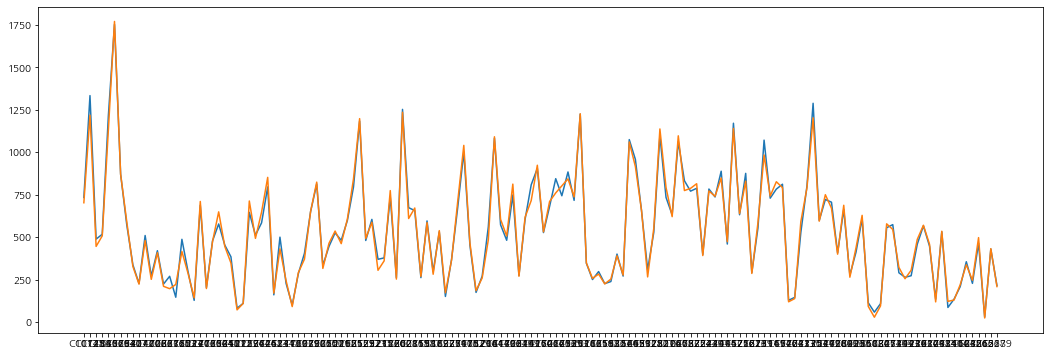

In [107]:
import matplotlib.pyplot as plt


best_score = pd.read_csv('./result/result6_3.csv')
danji_score = new_test['단지내주차면수']
current_score = pd.read_csv('./result/result7_1.csv')
print(mean_absolute_error(best_score['num'], current_score['num']))

plt.figure(figsize=(18,6))
plt.plot(best_score['code'], best_score['num'])
plt.plot(current_score['code'], current_score['num'])

# plt.plot(best_score['code'], danji_score)
plt.show()